<a href="https://colab.research.google.com/github/yarkalm/sale_regression/blob/main/Clean_salest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача регрессии: определить количество покупок в день по дате

In [176]:
import pandas as pd
import numpy as np
from keras.callbacks import ModelCheckpoint
import random
import tensorflow as tf
from keras import models
from keras.layers import Dense, Dropout, LSTM
from keras import Sequential, regularizers
from keras.optimizers import Adam, SGD
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [177]:
seed = 3
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#  Загрузка и предобработка данных

In [178]:
nmn_1 = pd.read_csv("/content/clean_sales_fabric_96_sku_265_warehouse_1.csv")

In [179]:
nmn_2 = pd.read_csv("/content/clean_sales_fabric_42_sku_13653_warehouse_-1.csv")

In [180]:
nmn_1 = nmn_1.sort_values(by = 'date')
nmn_2 = nmn_2.sort_values(by = 'date')

In [181]:
df = pd.concat([nmn_1, nmn_2], ignore_index = True)

In [182]:
df.reset_index(inplace = True)

In [183]:
date = df['date'].str.split('-').to_numpy()

In [184]:
for i in range(len(date)):
  date[i] = np.asarray(list(map(int,date[i]))).astype(np.float32)

In [185]:
year = []
month = []
day = []
for i in range(len(date)):
  today = date[i]
  year.append(today[0])
  month.append(today[1])
  day.append(today[2])

In [186]:
df['date'] = date
df['year'] = year
df['month'] = month
df['day'] = day
scaler = StandardScaler()
data, target = (scaler.fit_transform(df[['year','month','day']])),df['count'].astype(int)

In [187]:
x = []
y = []
timesteps = 6
for i in range(timesteps, len(data)):
# Кодирование даты
  x.append(np.array(data[i-timesteps:i]))
  y.append(target[i])

x, y = np.array(x), np.array(y)

In [188]:
x_1 = x[:len(nmn_1)]
y_1 = y[:len(nmn_1)]

x_2 = x[len(df)-len(nmn_2):]
y_2 = y[len(df)-len(nmn_2):]

In [189]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, train_size = 0.7)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, train_size = 0.7)

In [190]:
x_train_1.shape, x_test_1.shape, y_train_1.shape, y_test_1.shape, x_train_2.shape, x_test_2.shape, y_train_2.shape, y_test_2.shape

((132, 6, 3), (57, 6, 3), (132,), (57,), (6, 6, 3), (3, 6, 3), (6,), (3,))

# Создание модели для 1 номенклатуры

In [191]:
model_1 = Sequential()
model_1.add(LSTM(10, input_shape=(x_train_1.shape[1], x_train_1.shape[-1]), return_sequences=True))
model_1.add(LSTM(5))
model_1.add(Dense(1))

In [192]:
model_1.compile(loss = 'mse', optimizer = Adam(learning_rate=0.01),metrics = 'mae')

In [193]:
filepath="/content/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Обучение

In [ ]:
history = model_1.fit(x_train_1, y_train_1, epochs=500, batch_size=64,validation_split=0.2, verbose=2, callbacks = callbacks_list)

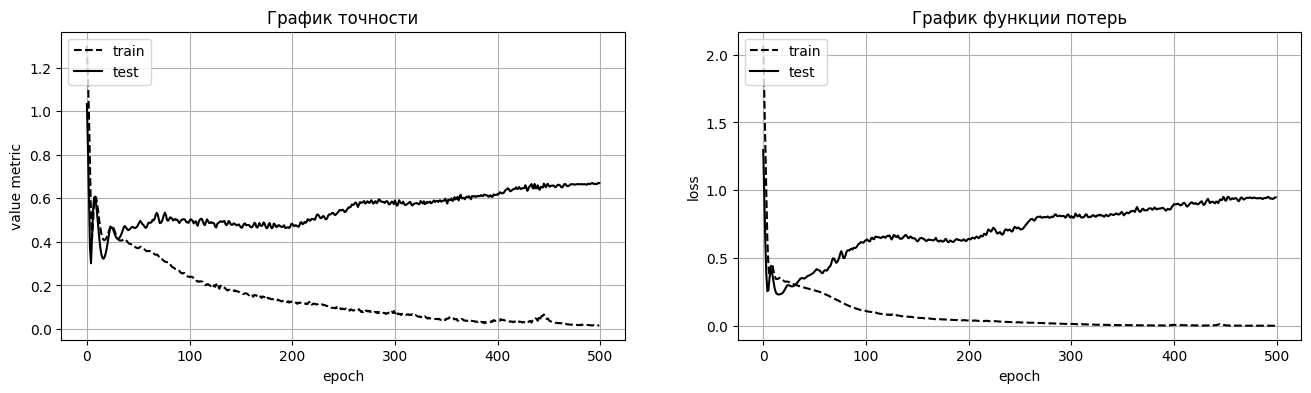

In [195]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(121)
ax.plot(history.history['mae'],'--',color='black')
ax.plot(history.history['val_mae'],color='black')
ax.set_title('График точности')
ax.set_ylabel('value metric')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'],'--',color='black')
ax2.plot(history.history['val_loss'],color='black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()

# Прогнозы на тестовых данных

In [196]:
#model_1 = models.load_model('best.h5')

In [212]:
result_1 = model_1.evaluate(x_test_1,y_test_1)
print(f"Loss model_1: {result_1[0]}\nMetric model_1: {result_1[1]}")

2/2 [==============================] - 0s 8ms/step - loss: 0.6144 - mae: 0.5382
Loss model_1: 0.6143915057182312
Metric model_1: 0.5382283926010132


In [213]:
test_1 = pd.DataFrame()
test_1['date'] = nmn_1.date[len(x_1)-len(x_test_1):len(x_1)]
test_1['year'] = year[len(x_1)-len(x_test_1):len(x_1)]
test_1['month'] = month[len(x_1)-len(x_test_1):len(x_1)]
test_1['day'] = day[len(x_1)-len(x_test_1):len(x_1)]

test_1['y_pred'] = list(np.around(model_1.predict(x_test_1)*1,0))
test_1['y_pred'] = test_1['y_pred'].str.get(0)
test_1['y_real'] = y_test_1

2/2 [==============================] - 0s 7ms/step


In [214]:
test_1

,date,year,month,day,y_pred,y_real
186,2018-01-09,2018.0,1.0,9.0,2.0,2
174,2018-01-11,2018.0,1.0,11.0,2.0,2
119,2018-01-15,2018.0,1.0,15.0,1.0,1
118,2018-01-17,2018.0,1.0,17.0,1.0,1
117,2018-01-25,2018.0,1.0,25.0,2.0,1
153,2018-02-07,2018.0,2.0,7.0,2.0,1
116,2018-02-11,2018.0,2.0,11.0,1.0,1
154,2018-02-14,2018.0,2.0,14.0,1.0,2
155,2018-02-14,2018.0,2.0,14.0,2.0,1
114,2018-02-23,2018.0,2.0,23.0,1.0,2


In [200]:
model_1.save('best.h5')

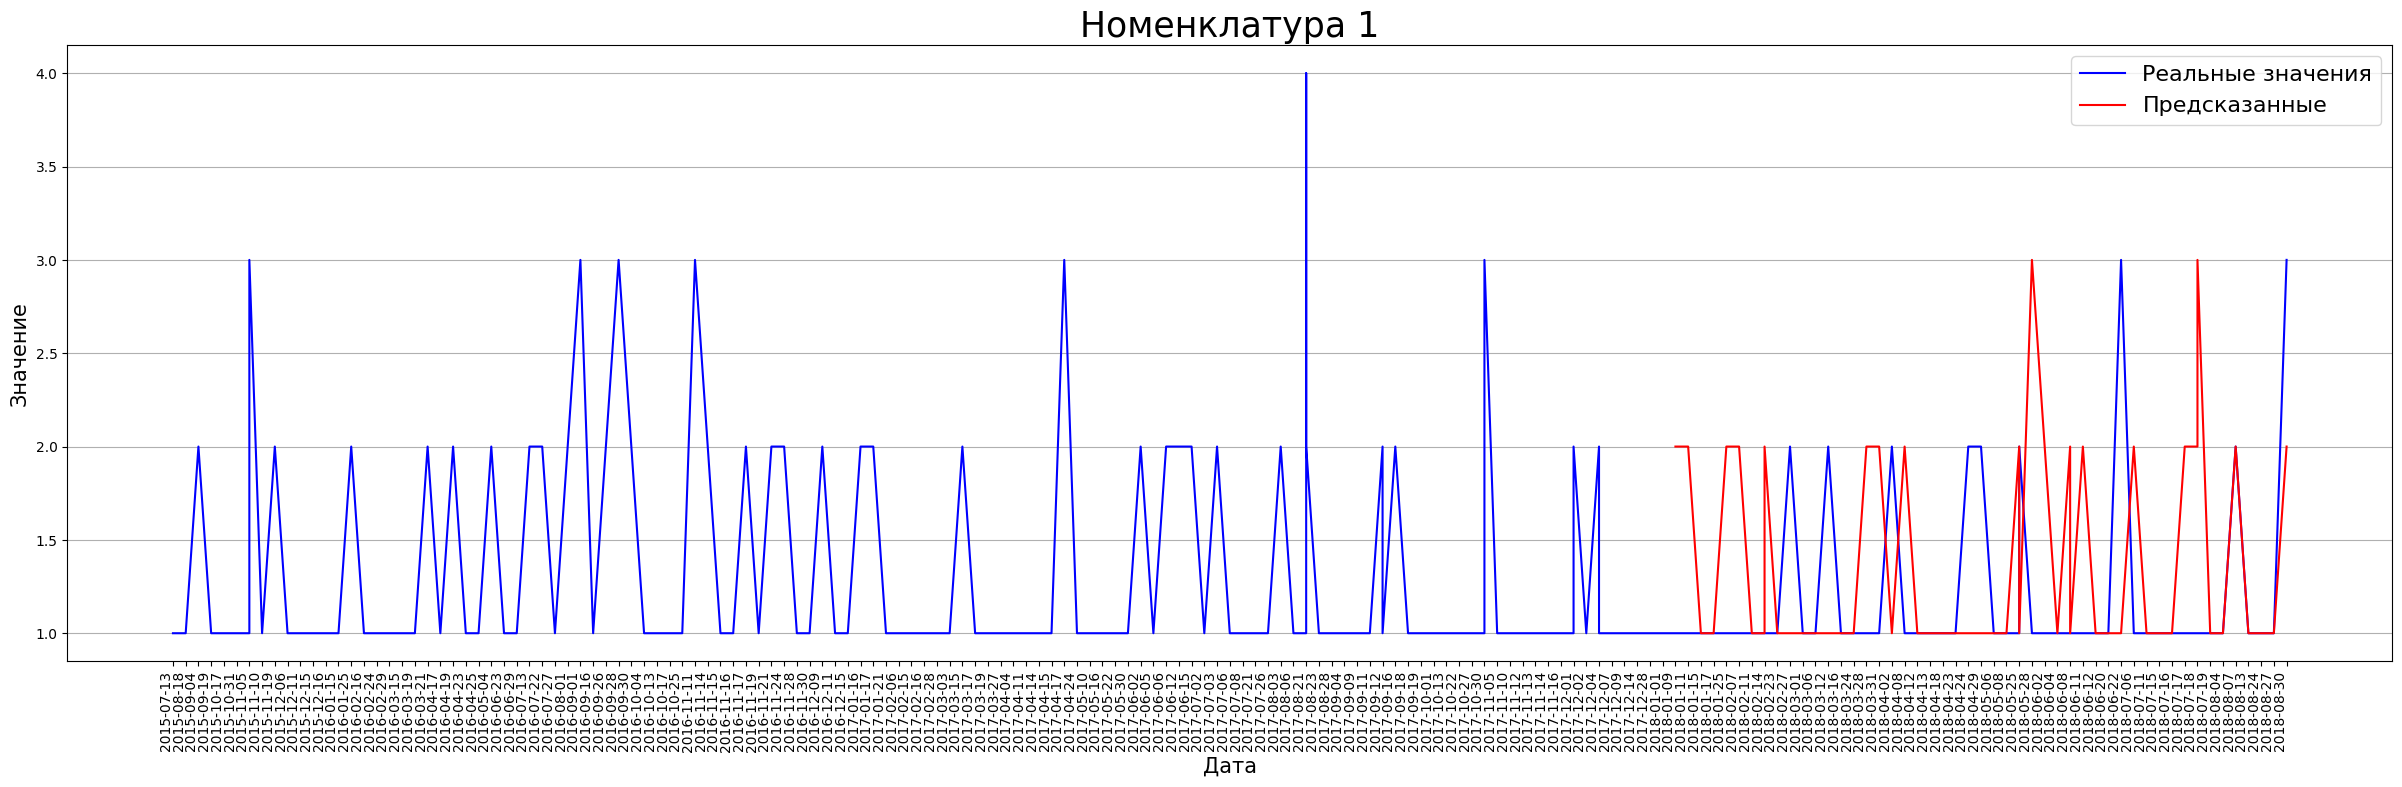

In [215]:
plt.figure(figsize = (30,8))
plt.xticks(rotation=90, ha='right')
plt.title('Номенклатура 1',fontsize = 25)
plt.grid(True, axis = 'y')
plt.plot(nmn_1.date,nmn_1['count'], color = 'b')
plt.plot(test_1.date,test_1.y_pred, color = 'r')
plt.gca().set_xlabel('Дата',fontsize = 15)
plt.gca().set_ylabel('Значение',fontsize = 15)
plt.legend(['Реальные значения','Предсказанные'],prop={'size': 16})

#Создание модели для 2 номенклатуры

In [202]:
model_2 = Sequential()
model_2.add(LSTM(4, input_shape=(x_train_1.shape[1], x_train_1.shape[-1]), return_sequences=True))
model_2.add(LSTM(2))
model_2.add(Dense(1))

In [203]:
model_2.compile(loss = 'mse', optimizer = Adam(learning_rate=0.1), metrics = 'mae')

In [204]:
filepath="/content/best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = model_2.fit(x_train_1, y_train_1, epochs=100, batch_size=16,validation_split=0.25, verbose=2, callbacks = callbacks_list)

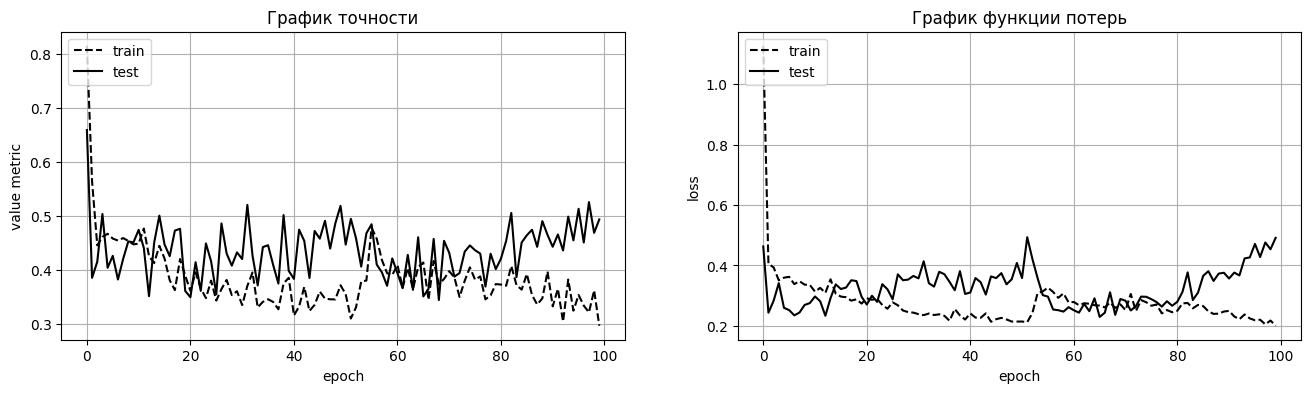

In [206]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(121)
ax.plot(history.history['mae'],'--',color='black')
ax.plot(history.history['val_mae'],color='black')
ax.set_title('График точности')
ax.set_ylabel('value metric')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax.grid(True)
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'],'--',color='black')
ax2.plot(history.history['val_loss'],color='black')
ax2.set_title('График функции потерь')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
ax2.grid(True)
plt.show()

In [207]:
result_2 = model_2.evaluate(x_test_2,y_test_2)
print(f"Loss model_2: {result_2[0]}\nMetric model_2: {result_2[1]}")

1/1 [==============================] - 0s 31ms/step - loss: 0.0800 - mae: 0.1714
Loss model_2: 0.08002501726150513
Metric model_2: 0.17140264809131622


In [208]:
test_2 = pd.DataFrame()
test_2['date'] = nmn_2.date[len(x_2)-len(x_test_2)+timesteps:]
test_2['year'] = year[len(x)-len(x_test_2)+timesteps:]
test_2['month'] = month[len(x)-len(x_test_2)+timesteps:]
test_2['day'] = day[len(x)-len(x_test_2)+timesteps:]

test_2['y_pred'] = list(np.around(model_2.predict(x_test_2)*1,0))
test_2['y_pred'] = test_2['y_pred'].str.get(0)
test_2['y_real'] = y_test_2

1/1 [==============================] - 1s 825ms/step


In [209]:
test_2

,date,year,month,day,y_pred,y_real
6,2018-04-23,2018.0,4.0,23.0,1.0,1
10,2018-07-17,2018.0,7.0,17.0,1.0,1
9,2018-07-18,2018.0,7.0,18.0,1.0,1


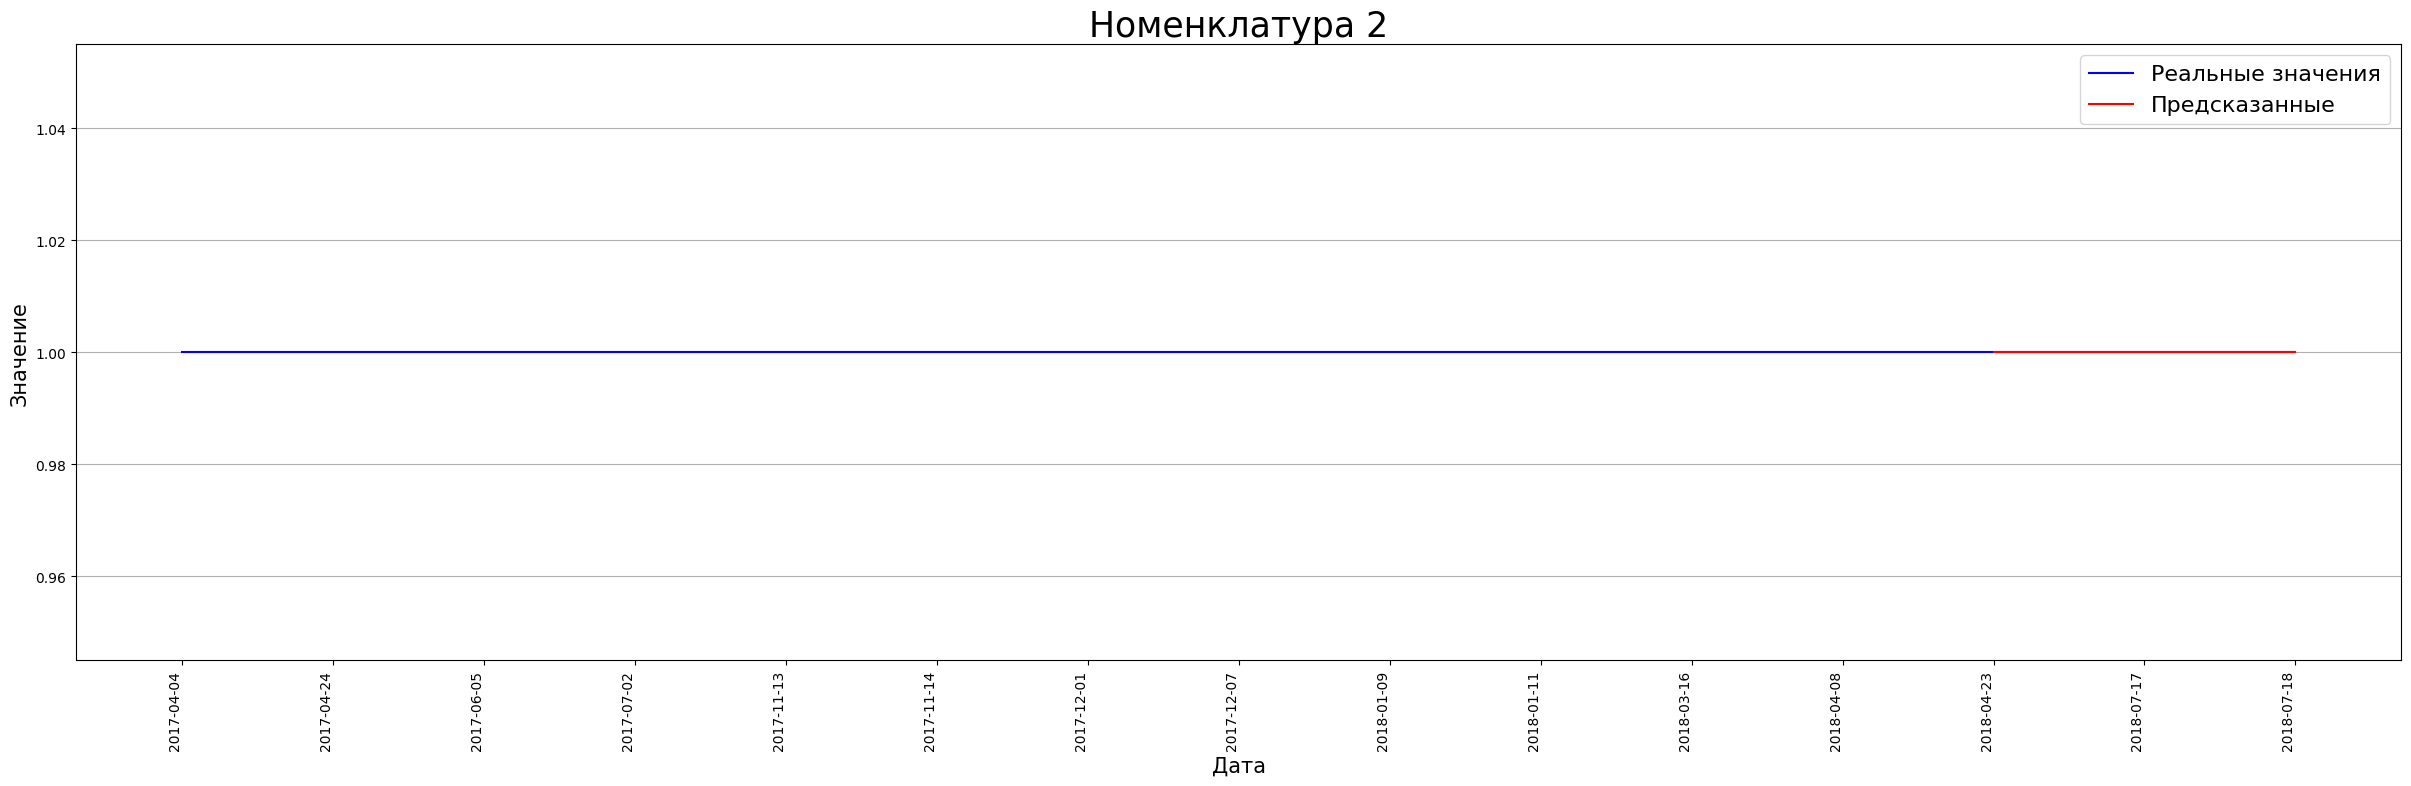

In [210]:
plt.figure(figsize = (30,8))
plt.xticks(rotation=90, ha='right')
plt.title('Номенклатура 2',fontsize = 25)
plt.grid(True, axis = 'y')
plt.plot(nmn_2.date,nmn_2['count'], color = 'b')
plt.plot(test_2.date,test_2.y_pred, color = 'r')
plt.gca().set_xlabel('Дата',fontsize = 15)
plt.gca().set_ylabel('Значение',fontsize = 15)
plt.legend(['Реальные значения','Предсказанные'],prop={'size': 16})